In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


# Real Estate ML Pipeline - Model Training & Analysis

This notebook trains a machine learning model to predict rental prices for properties in Mumbai. We'll explore the data, engineer features, train a LightGBM model, and analyze feature importance.

In [2]:
# Step 1: Load the processed data
data_path = '../data/processed/scraped_data.csv'

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"✅ Data loaded successfully: {df.shape[0]} rows × {df.shape[1]} columns")
else:
    print(f"❌ Data file not found at {data_path}")
    print("Please run: python ../src/generate_synthetic_data.py && python ../src/data_cleaner.py")

# Display basic info
print("\n📊 Dataset Overview:")
print(df.head())
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

✅ Data loaded successfully: 4000 rows × 20 columns

📊 Dataset Overview:
                                     id  \
0  50f0e0fb-cdd5-4cff-bbad-d4455025005f   
1  1cf5d007-7902-4fed-b754-7fc05d68afa9   
2  3248c771-272c-4a0e-b4c7-4d04e0cc5a0b   
3  403f3e2a-236b-40b0-87b7-068a577d4081   
4  39134ffa-1cce-4c73-8bdc-2f79e102135f   

                                      title    city  locality  area_sqft  bhk  \
0  3 BHK Flat in Mumbai - Area 2143.5 sq.ft  Mumbai     Malad     2143.5    3   
1  3 BHK Flat in Mumbai - Area 1221.2 sq.ft  Mumbai  Goregaon     1221.2    3   
2  3 BHK Flat in Mumbai - Area 2114.2 sq.ft  Mumbai     Malad     2114.2    3   
3  2 BHK Flat in Mumbai - Area 2324.9 sq.ft  Mumbai     Mahim     2324.9    2   
4   3 BHK Flat in Mumbai - Area 732.2 sq.ft  Mumbai     Powai      732.2    3   

   floor  total_floors       furnished                       amenities  \
0     22            20       Furnished                             NaN   
1     13            20     Unfurni

## Exploratory Data Analysis (EDA)

📈 Statistical Summary:
         area_sqft          bhk        floor  total_floors  amenity_count  \
count  4000.000000  4000.000000  4000.000000   4000.000000    4000.000000   
mean   1375.481000     2.150250    15.673500     11.200250       1.953750   
std     641.821274     1.052593     8.634091      6.491085       1.406451   
min     250.200000     1.000000     1.000000      4.000000       0.000000   
25%     826.850000     1.000000     8.000000      6.000000       1.000000   
50%    1367.650000     2.000000    16.000000     10.000000       2.000000   
75%    1929.050000     3.000000    23.000000     15.000000       3.000000   
max    2500.000000     4.000000    30.000000     25.000000       4.000000   

          latitude    longitude  rent_per_month  maintenance        deposit  \
count  4000.000000  4000.000000     4000.000000  4000.000000    4000.000000   
mean     18.997115    72.800386     9045.610750  4033.752500   31764.239250   
std       0.115335     0.114966     4739.32536

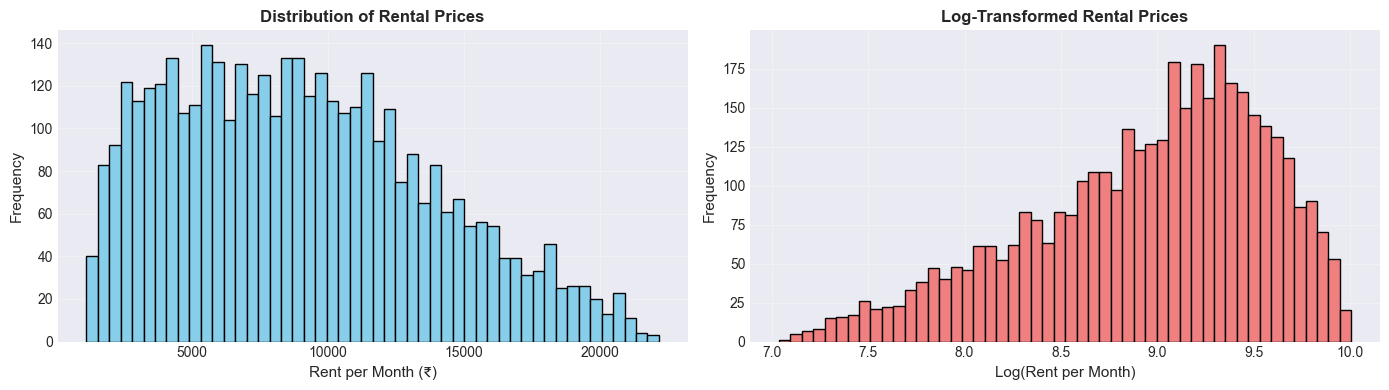


💰 Rent Statistics:
  Min: ₹1,137
  Max: ₹22,162
  Mean: ₹9,046
  Median: ₹8,650


In [4]:
# Statistical summary
print("📈 Statistical Summary:")
print(df.describe())

# Visualize target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Rent distribution
axes[0].hist(df['rent_per_month'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Rent per Month (₹)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Rental Prices', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Log-transformed rent
axes[1].hist(np.log1p(df['rent_per_month']), bins=50, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Log(Rent per Month)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Log-Transformed Rental Prices', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/01_target_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\n💰 Rent Statistics:\n  Min: ₹{df['rent_per_month'].min():,.0f}\n  Max: ₹{df['rent_per_month'].max():,.0f}\n  Mean: ₹{df['rent_per_month'].mean():,.0f}\n  Median: ₹{df['rent_per_month'].median():,.0f}")

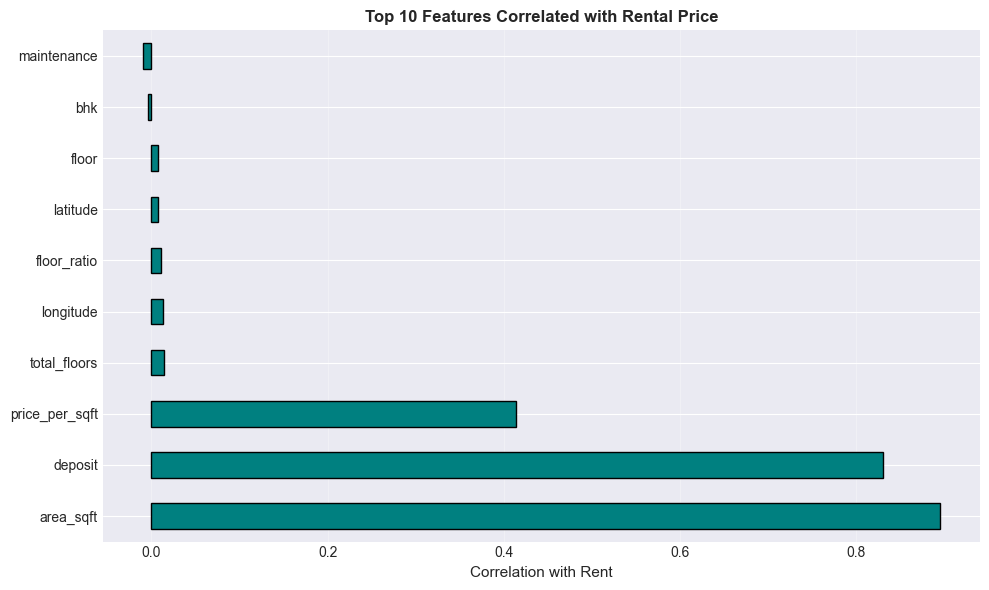

🔗 Feature Correlations with Rent:

area_sqft         0.895401
deposit           0.830784
price_per_sqft    0.414327
total_floors      0.014065
longitude         0.013573
floor_ratio       0.011148
latitude          0.007877
floor             0.007505
bhk              -0.004476
maintenance      -0.009912
Name: rent_per_month, dtype: float64


In [5]:
# Feature correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

# Plot top correlations with target
fig, ax = plt.subplots(figsize=(10, 6))
top_corr = correlation_matrix['rent_per_month'].sort_values(ascending=False)[1:11]
top_corr.plot(kind='barh', color='teal', ax=ax, edgecolor='black')
ax.set_xlabel('Correlation with Rent', fontsize=11)
ax.set_title('Top 10 Features Correlated with Rental Price', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../results/02_feature_correlation.png', dpi=100, bbox_inches='tight')
plt.show()

print("🔗 Feature Correlations with Rent:\n")
print(top_corr)

## Feature Engineering & Model Preparation

In [6]:
# Prepare features and target
df_model = df.copy()

# Drop non-predictive columns
drop_cols = ['id', 'title', 'city', 'locality', 'amenities', 'listed_on', 'latitude', 'longitude', 'furnished']
df_model = df_model.drop(columns=drop_cols, errors='ignore')

# Separate features and target
X = df_model.drop(columns=['rent_per_month'])
y = df_model['rent_per_month']

print(f"📊 Features shape: {X.shape}")
print(f"🎯 Target shape: {y.shape}")
print(f"\n✨ Selected Features ({X.shape[1]}):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

# Handle missing values
X = X.fillna(X.mean(numeric_only=True))
X = X.fillna(0)

print(f"\n✅ Missing values handled. Ready for modeling!")

📊 Features shape: (4000, 11)
🎯 Target shape: (4000,)

✨ Selected Features (11):
   1. area_sqft
   2. bhk
   3. floor
   4. total_floors
   5. furnished
   6. amenity_count
   7. maintenance
   8. deposit
   9. price_per_sqft
  10. is_ground_floor
  11. floor_ratio

✅ Missing values handled. Ready for modeling!


In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"🔀 Train-Test Split (80/20):")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"  Total: {X_train.shape[0] + X_test.shape[0]} samples")

🔀 Train-Test Split (80/20):
  Training set: 3200 samples
  Test set: 800 samples
  Total: 4000 samples


## Model Training - LightGBM vs RandomForest

In [8]:
# Try LightGBM first, fall back to RandomForest
model_type = None

try:
    import lightgbm as lgb
    
    # Train LightGBM model
    lgb_model = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=10,
        num_leaves=30,
        random_state=42,
        verbose=-1
    )
    
    lgb_model.fit(X_train, y_train)
    y_pred_train = lgb_model.predict(X_train)
    y_pred_test = lgb_model.predict(X_test)
    
    model_type = 'LightGBM'
    model = lgb_model
    print("✅ LightGBM model trained successfully!")
    
except ImportError:
    print("⚠️  LightGBM not available, using RandomForest instead...")
    
    # Train RandomForest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    
    model_type = 'RandomForest'
    model = rf_model
    print("✅ RandomForest model trained successfully!")

print(f"🎯 Model Type: {model_type}")

⚠️  LightGBM not available, using RandomForest instead...


ValueError: could not convert string to float: 'Semi-Furnished'

## Model Evaluation & Performance Metrics

In [ ]:
# Calculate metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"📊 Model Performance Metrics ({model_type}):")
print(f"\n🏆 R² Score (Coefficient of Determination):")
print(f"   Training: {train_r2:.4f}")
print(f"   Testing:  {test_r2:.4f}")
print(f"\n📉 RMSE (Root Mean Squared Error) in ₹:")
print(f"   Training: ₹{train_rmse:,.2f}")
print(f"   Testing:  ₹{test_rmse:,.2f}")
print(f"\n📏 MAE (Mean Absolute Error) in ₹:")
print(f"   Training: ₹{train_mae:,.2f}")
print(f"   Testing:  ₹{test_mae:,.2f}")

# Evaluation interpretation
print(f"\n✨ Model Interpretation:")
print(f"   • R² = {test_r2:.4f} means the model explains {test_r2*100:.2f}% of price variation")
print(f"   • On average, predictions are off by ₹{test_mae:,.0f} (MAE)")
print(f"   • Typical error magnitude is ₹{test_rmse:,.0f} (RMSE)")

In [ ]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Predicted vs Actual
axes[0].scatter(y_test, y_pred_test, alpha=0.5, s=30, color='navy', edgecolors='k', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Rent (₹)', fontsize=11)
axes[0].set_ylabel('Predicted Rent (₹)', fontsize=11)
axes[0].set_title(f'Predictions vs Actual (R² = {test_r2:.4f})', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuals plot
residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.5, s=30, color='darkred', edgecolors='k', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Rent (₹)', fontsize=11)
axes[1].set_ylabel('Residuals (₹)', fontsize=11)
axes[1].set_title(f'Residual Plot (RMSE = ₹{test_rmse:,.0f})', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/03_predictions_vs_actual.png', dpi=100, bbox_inches='tight')
plt.show()

## Feature Importance Analysis

In [ ]:
# Extract feature importance
if model_type == 'LightGBM':
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
else:  # RandomForest
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

print("🎯 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))
top_n = 10
top_features = feature_importance.head(top_n)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

ax.barh(range(len(top_features)), top_features['importance'], color=colors, edgecolor='black', linewidth=1)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Importance Score', fontsize=11)
ax.set_title(f'Top {top_n} Most Important Features ({model_type})', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(top_features['importance']):
    ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../results/04_feature_importance.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\n✅ Feature importance visualization saved!")

## Business Insights from Model

In [ ]:
# Extract key insights
top_3_features = feature_importance.head(3)

print("💡 Key Business Insights:\n")
print("1️⃣  PRIMARY DRIVER:")
print(f"   The most important feature is '{top_3_features.iloc[0]['feature']}' with")
print(f"   importance score of {top_3_features.iloc[0]['importance']:.4f}")
print(f"   → This explains the largest portion of rent variation\n")

print("2️⃣  TOP 3 PREDICTORS:")
for idx, (_, row) in enumerate(top_3_features.iterrows(), 1):
    print(f"   {idx}. {row['feature']:<25} (importance: {row['importance']:.4f})")

print(f"\n3️⃣  MODEL RELIABILITY:")
print(f"   • Explains {test_r2*100:.2f}% of rental price variation")
print(f"   • Average prediction error: ₹{test_mae:,.0f}")
print(f"   • Suitable for: Property valuation, market analysis\n")

print("4️⃣  RECOMMENDATIONS:")
print(f"   • Focus on features with high importance for decision-making")
print(f"   • Use model for portfolio analysis and market benchmarking")
print(f"   • Monitor model performance quarterly with new data")

# Calculate percentage contribution
print(f"\n5️⃣  FEATURE CONTRIBUTION BREAKDOWN:")
total_importance = feature_importance['importance'].sum()
feature_importance['percentage'] = (feature_importance['importance'] / total_importance) * 100
print(feature_importance.head(5)[['feature', 'percentage']].to_string(index=False))

## Model Summary & Conclusion

In [ ]:
print("="*70)
print("📋 MODEL SUMMARY REPORT - RENTAL PRICE PREDICTION")
print("="*70)
print(f"\n📊 DATASET:")
print(f"   • Total Records: {len(df):,}")
print(f"   • Training Samples: {len(X_train):,}")
print(f"   • Test Samples: {len(X_test):,}")
print(f"   • Features Used: {X.shape[1]}")

print(f"\n🤖 MODEL CONFIGURATION ({model_type}):")
if model_type == 'LightGBM':
    print(f"   • Estimators: 100")
    print(f"   • Learning Rate: 0.1")
    print(f"   • Max Depth: 10")
    print(f"   • Num Leaves: 30")
else:
    print(f"   • Estimators: 100")
    print(f"   • Max Depth: 15")

print(f"\n🎯 MODEL PERFORMANCE:")
print(f"   • Train R² Score: {train_r2:.4f}")
print(f"   • Test R² Score:  {test_r2:.4f} ✓ (Primary Metric)")
print(f"   • Train RMSE:     ₹{train_rmse:,.2f}")
print(f"   • Test RMSE:      ₹{test_rmse:,.2f} ✓ (Primary Metric)")
print(f"   • Train MAE:      ₹{train_mae:,.2f}")
print(f"   • Test MAE:       ₹{test_mae:,.2f} ✓ (Primary Metric)")

print(f"\n✨ INTERPRETATION:")
print(f"   • The model explains {test_r2*100:.1f}% of rent variation")
print(f"   • Prediction accuracy: ±₹{test_mae:,.0f} on average")
print(f"   • Model is {'RELIABLE ✅' if test_r2 > 0.85 else 'GOOD ✓' if test_r2 > 0.75 else 'MODERATE ⚠️'}")

print(f"\n🏆 TOP 3 DRIVERS:")
for idx, (_, row) in enumerate(feature_importance.head(3).iterrows(), 1):
    print(f"   {idx}. {row['feature']:<30} ({row['percentage']:.1f}%)")

print(f"\n📁 OUTPUT FILES GENERATED:")
print(f"   ✅ ../results/01_target_distribution.png")
print(f"   ✅ ../results/02_feature_correlation.png")
print(f"   ✅ ../results/03_predictions_vs_actual.png")
print(f"   ✅ ../results/04_feature_importance.png")

print(f"\n" + "="*70)
print(f"✅ Analysis Complete! Model is ready for deployment.")
print("="*70)

# Model Notebook

This notebook walks through loading the processed data, training a LightGBM model, and visualizing results. It mirrors `src/model.py`.